Dataset from https://www.kaggle.com/datasets/techsash/waste-classification-data

Task: binary classification (or mutiple, depends) of waste as either organic or recycleable

In [19]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics  import accuracy_score
from PIL import Image

from keras.utils.vis_utils import plot_model
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization

import tensorflow as tf
# example of converting an image with the Keras API
from tensorflow.keras.preprocessing.image import load_img , img_to_array, ImageDataGenerator, array_to_img
make_dataset = tf.keras.utils.image_dataset_from_directory


In [2]:
data_path = r'D:\Data for python\datasets\Waste Classification data\DATASET'

In [3]:
organic = []
recycleable = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(root, file)
            if file.startswith("O_"):
                organic.append(file_path)
            elif file.startswith("R_"):
                recycleable.append(file_path)

len(organic), len(recycleable)

(13966, 13966)

check for imbalance

In [4]:
defficit = len(organic) - len(recycleable)
defficit

0

In [5]:
22222 / (27932 + 22222)

0.44307532798979143

Augmenting the smaller class  "recycleable"

In [6]:
defficit = len(organic) - len(recycleable)
defficit = 0 if defficit < 0 else defficit  # in case the code is run again 
random_indexes = np.random.randint(0, len(recycleable), defficit)
smaller_class = recycleable

def derive_image(path):
    # Load the image
    img = load_img(path)
    # Convert the image to a numpy array
    x = img_to_array(img)
    # Create an image data generator with reasonable transformations
    datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2)
    # Apply a random transformation to the image
    x_aug = datagen.random_transform(x)
    #Convert the augmented numpy array back to a PIL image
    img_aug = array_to_img(x_aug)
    # Make a new name for the generated file
    dir_path, file_name = os.path.split(path)
    new_file_name = os.path.splitext(file_name)[0] + "_gen.jpg"
    save_path = os.path.join(dir_path, new_file_name)
    # Save the augmented image in the same directory as the original image
    img_aug.save(save_path)


for i in random_indexes:
    chosen_img_path = recycleable[i]
    derive_image(chosen_img_path)



In [7]:
organic = []
recycleable = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(root, file)
            if file.startswith("O_"):
                organic.append(file_path)
            elif file.startswith("R_"):
                recycleable.append(file_path)

len(organic), len(recycleable)

(13966, 13966)

In [8]:
def plot_color_image(image, title="name"):
    img = mpl.image.imread(image)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def plot_image_uint(image, title="name"):
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()    

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")    

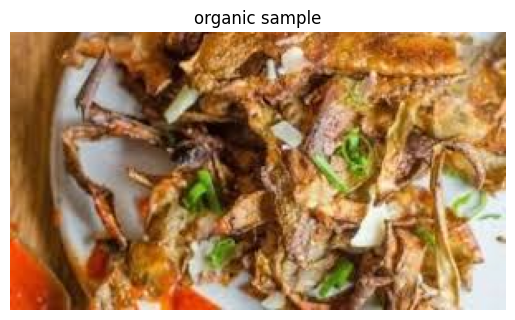

In [9]:
plot_color_image(organic[8000], "organic sample")

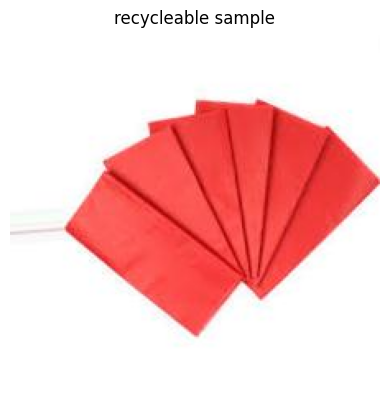

In [10]:
plot_color_image(recycleable[1500], "recycleable sample")

In [11]:
labels_org = [0] *  len(organic)
labels_rec = [1] * len(recycleable)
data = organic + recycleable
labels = labels_org + labels_rec


making a dataset and resizing the images to 224 x 224

In [41]:
# Create the training dataset with data augmentation
train_dataset = make_dataset(data_path, image_size=(224,224), labels="inferred", label_mode ="int", subset="training", validation_split = 0.2, seed=33)

# Use the same validation dataset as before
validation_dataset = make_dataset(data_path, image_size=(224,224),labels="inferred", label_mode ="int", subset="validation", validation_split = 0.2, seed=33)

Found 27932 files belonging to 2 classes.
Using 22346 files for training.
Found 27932 files belonging to 2 classes.
Using 5586 files for validation.


In [13]:
train_dataset.class_names

['0', '1']

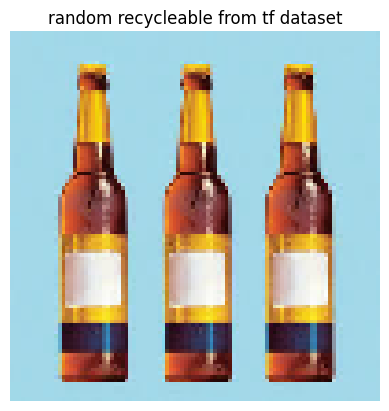

In [38]:
inspect= 0
images, labels = next(iter(train_dataset))
image = images[inspect]
image = image.numpy().astype("uint8")
label = "organic" if labels[inspect].numpy() == 0 else "recycleable"

plot_image_uint(image, f"random {label} from tf dataset")

In [15]:
from sklearn.metrics import f1_score
import tensorflow as tf

def f1(y_true, y_pred):
    y_true = tf.cast(y_true, "float32")
    y_pred = tf.cast(tf.round(y_pred), "float32")
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [17]:
# num_classes = 2
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 4, 2, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(48, 2, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(48, 2, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(48, 2, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(1, activation= "softmax")
# ])

# optimizer = tf.keras.optimizers.Nadam(learning_rate=0.003)
# model.compile(
#   optimizer= optimizer,
#   loss=tf.keras.losses.BinaryCrossentropy(),
#   metrics=[f1])


# history = model.fit(
#   train_dataset,
#   validation_data=validation_dataset,
#   epochs=3
# )  


My model doesn't seem to be able to solve the task.

Testing a model from BEYZA NUR NAKKAŞ  https://www.kaggle.com/code/beyzanks/waste-classification-with-cnn/notebook

In [43]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(2)) # output
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

In [45]:
# history = model.fit(
#   train_dataset,
#   validation_data=validation_dataset,
#   epochs=3
# )  


In [26]:
model.save('CNN waste classifier.h5')

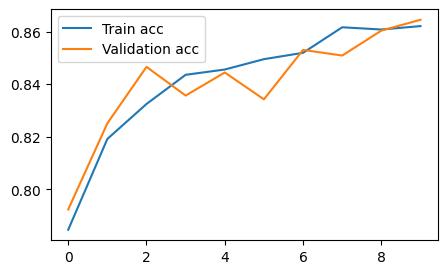

In [30]:
plt.figure(figsize=[5,3])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

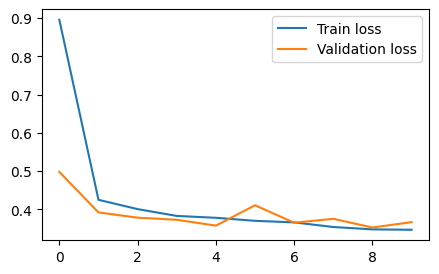

In [29]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [31]:
samples_path = r'D:\Data for python\datasets\Waste Classification data\sample'
samples = [os.path.join(samples_path, file) for file in os.listdir(samples_path) if file.endswith(".jpg")]
test_samples = []
for path in samples:
    image = Image.open(path)
    resized_image = image.resize((100, 100))
    normalized_image = np.array(resized_image) / 255
    test_samples.append(normalized_image)
    
test_samples = np.array(test_samples)
preds = model.predict(test_samples)

1/1 [==============================] - 0s 341ms/step


Conclusion : My first model was insufficient for this task, and the model copied from from BEYZA is much better at discovering patterns in the image data but requires a more powerful computer for training. Mine took 70 minutes with downscaling the images to 100x100 and achieved 86% accuracy. BEIZA on the other hand used 224x224 images and 10 epochs, which would increase the training time along with the prediction accuracy.